# SUMMARY
| |  |
|:---       | :---          |
|**Step 1** | Loading Data  |
|**Step 2** | Naive Bayes   |
|**Step 3** | Decision Tree |
|**Step 4** | Random Forest |






In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 1. Loading Data
The code loads two datasets, train_data and test_data, from pickle files


Both train and test files can be found [HERE](https://drive.google.com/drive/folders/1gvMmhOzTojPdIc9fxj-JlgzH6Q3YMogF?usp=sharing)

In [2]:
with open('train_data.pkl', 'rb') as file:
  train_data = pickle.load(file)

with open('test_data.pkl', 'rb') as file:
  test_data = pickle.load(file)


# Display columns
test_data['ABEV3'].columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'EMA 13', 'RSI', 'OBV', 'SAR', 'ATR', 'Upper Band', 'Lower Band',
       'EPS TTM', 'Dividends TTM', 'VPA TTM', 'P/L', 'P/VPA', 'DIV YIELD',
       'Sent. Negative', 'Sent. Positive', 'Sent. Neutral', 'Next Return',
       'Output'],
      dtype='object', name='Price')

#### a) Defining Columns

In this section, the datasets are prepared for model training:

* First, unwanted columns are removed.
* Then, the data is split into features (X) and target (Y) for both the training and testing datasets. The features consist of all columns except the last one, while the target is the last column.
* Finally, the processed data is stored in a nested dictionary for both training and testing datasets.

In [3]:
# Removing unwanted columns:
columns_to_remove = ['Close', 'High', 'Low', 'Open', 'Next Return']

# Train data:
for key, df in train_data.items():
    train_data[key] = df.drop(columns=columns_to_remove, errors='ignore').dropna()

# Test data:
for key, df in test_data.items():
    test_data[key] = df.drop(columns=columns_to_remove, errors='ignore').dropna()


In [4]:
# Split into X and Y arrays and store in a nested dict:

# Train data:
train_data_transformed = {}

for key, df in train_data.items():
    X_train = df.iloc[:, :-1].values
    Y_train = df.iloc[:, -1].values

    # Store in a new nested dictionary
    train_data_transformed[key] = {'df': df, 'X_train': X_train,  'Y_train': Y_train }


# Test data:
test_data_transformed = {}

for key, df in test_data.items():
    X_test = df.iloc[:, :-1].values
    Y_test = df.iloc[:, -1].values

    # Store in a new nested dictionary
    test_data_transformed[key] = {'df': df, 'X_test': X_test,  'Y_test': Y_test }

#### b) Label Encoder

In this section, the target variable (Y) is encoded for model training. A LabelEncoder is applied to transform categorical target labels into numerical values for both the training and testing datasets. Each dataset's encoder is also stored for potential decoding later.


In [20]:
from sklearn.preprocessing import LabelEncoder

# Train_data:
for key, nested_dict in train_data_transformed.items():
    encoder = LabelEncoder()

    # Encode the Y_train array:
    nested_dict['Y_train'] = encoder.fit_transform(nested_dict['Y_train'])

    # Store the encoder:
    nested_dict['encoder'] = encoder


# Test_data:
for key, nested_dict in test_data_transformed.items():
    encoder = LabelEncoder()

    # Encode the Y_train array:
    nested_dict['Y_test'] = encoder.fit_transform(nested_dict['Y_test'])

    # Store the encoder:
    nested_dict['encoder'] = encoder

# Show output example:
print('Categorical data example:')
print(train_data_transformed['ABEV3']['df']['Output'].tolist()[:10])
print('\nEncoded data:')
print(train_data_transformed['ABEV3']['Y_train'])


#['Buy', 'Neutral', 'Sell', 'Strong Sell', 'Strong Buy']

Categorical data example:
['Neutral', 'Sell', 'Sell', 'Neutral', 'Neutral', 'Buy', 'Sell', 'Neutral', 'Neutral', 'Buy']

Encoded data:
[1 2 2 1 1 0 2 1 1 0 1 4 3 2 1 1 4 2 2 3 4 3 2 2 2 2 2 1 1 1 2 3 1 1 4 2 1
 2 2 1 0 2 3 1 1 1 1 2 1 1 1 1 1 1 2 3 1 0 4 0 1 1 2 2 1 3 2 1 4 0 1 2 1 1
 1 1 2 2 2 2 1 2]


## 2. Naive Bayes

#### c) Model Training

In [21]:
from sklearn.naive_bayes import GaussianNB

for key, nested_dict in train_data_transformed.items():
    NB = GaussianNB()
    NB.fit(nested_dict['X_train'], nested_dict['Y_train'] )

    # Store the model:
    nested_dict['model'] = NB


#### d) Predicting and Metrics

In [22]:
print('Accuracy of Naive Bayes Models')
for key, nested_dict in test_data_transformed.items():
  NB = train_data_transformed[key]['model']
  nested_dict['Predictions'] = NB.predict(nested_dict['X_test'])
  acc = accuracy_score(nested_dict['Y_test'], nested_dict['Predictions'])
  print(f"Asset: {key}  | Accuracy: {round(acc*100, 2)} %  ")


Accuracy of Naive Bayes Models
Asset: ABEV3  | Accuracy: 38.1 %  
Asset: B3SA3  | Accuracy: 33.33 %  
Asset: ELET3  | Accuracy: 38.1 %  
Asset: VALE3  | Accuracy: 38.1 %  
Asset: PETR4  | Accuracy: 14.29 %  
Asset: ITUB4  | Accuracy: 52.38 %  
Asset: IBOV  | Accuracy: 52.38 %  


## 3. Decision Tree

#### a) Creating Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

for key, nested_dict in train_data_transformed.items():
    # Inicialize classifier:
    tree_model = tree.DecisionTreeClassifier()

    # Fit the model:
    asset_model = tree_model.fit(nested_dict['X_train'], nested_dict['Y_train'])

    # Store the model and importances:
    nested_dict['model'] = asset_model
    nested_dict['Importances'] = pd.DataFrame(asset_model.feature_importances_,
                                columns = ['Importance'], index = nested_dict['df'].columns.tolist()[:-1]).sort_values('Importance', ascending = False)



#### b) Predictions and Accuracy:

In [24]:
print('Accuracy of Decision Tree Models')
for key, nested_dict in test_data_transformed.items():
  # Load the asset model:
  asset_model = train_data_transformed[key]['model']

  # Compute predictions:
  nested_dict['Predictions'] = asset_model.predict(nested_dict['X_test'])
  acc = accuracy_score(nested_dict['Y_test'], nested_dict['Predictions'])
  print(f"Asset: {key}  | Accuracy: {round(acc*100,2)} %  ")

Accuracy of Decision Tree Models
Asset: ABEV3  | Accuracy: 28.57 %  
Asset: B3SA3  | Accuracy: 19.05 %  
Asset: ELET3  | Accuracy: 19.05 %  
Asset: VALE3  | Accuracy: 9.52 %  
Asset: PETR4  | Accuracy: 28.57 %  
Asset: ITUB4  | Accuracy: 33.33 %  
Asset: IBOV  | Accuracy: 61.9 %  


#### c) Feature importance

In [25]:
for key, nested_dict in train_data_transformed.items():
  print(f' Asset: {key} \n', round(nested_dict['Importances']*100, 2))
  print('\n')

 Asset: ABEV3 
                 Importance
RSI                  18.51
Sent. Neutral        12.39
Volume               10.87
DIV YIELD             8.30
Upper Band            8.03
Sent. Positive        6.99
Return                6.73
EMA 13                6.26
Sent. Negative        6.21
ATR                   5.12
P/VPA                 3.97
P/L                   2.69
Adj Close             2.15
EPS TTM               1.79
VPA TTM               0.00
Dividends TTM         0.00
SAR                   0.00
OBV                   0.00
Lower Band            0.00


 Asset: B3SA3 
                 Importance
Volume               17.46
Return               16.90
EMA 13                9.11
RSI                   8.54
Sent. Positive        7.65
DIV YIELD             7.33
P/VPA                 6.22
Lower Band            4.52
Sent. Negative        4.38
Upper Band            3.62
OBV                   3.29
ATR                   3.29
Sent. Neutral         2.74
P/L                   1.65
VPA TTM              

#### d) Tree Visualization

In [27]:
# Picking ITUB4 tree as example:
asset_tree = train_data_transformed['ITUB4']['model']

# Defining class labels (ordered by encoding function):
class_labels = ['Buy', 'Neutral', 'Sell', 'Strong Sell', 'Strong Buy']

# Features:
features = train_data_transformed['ITUB4']['df'].columns

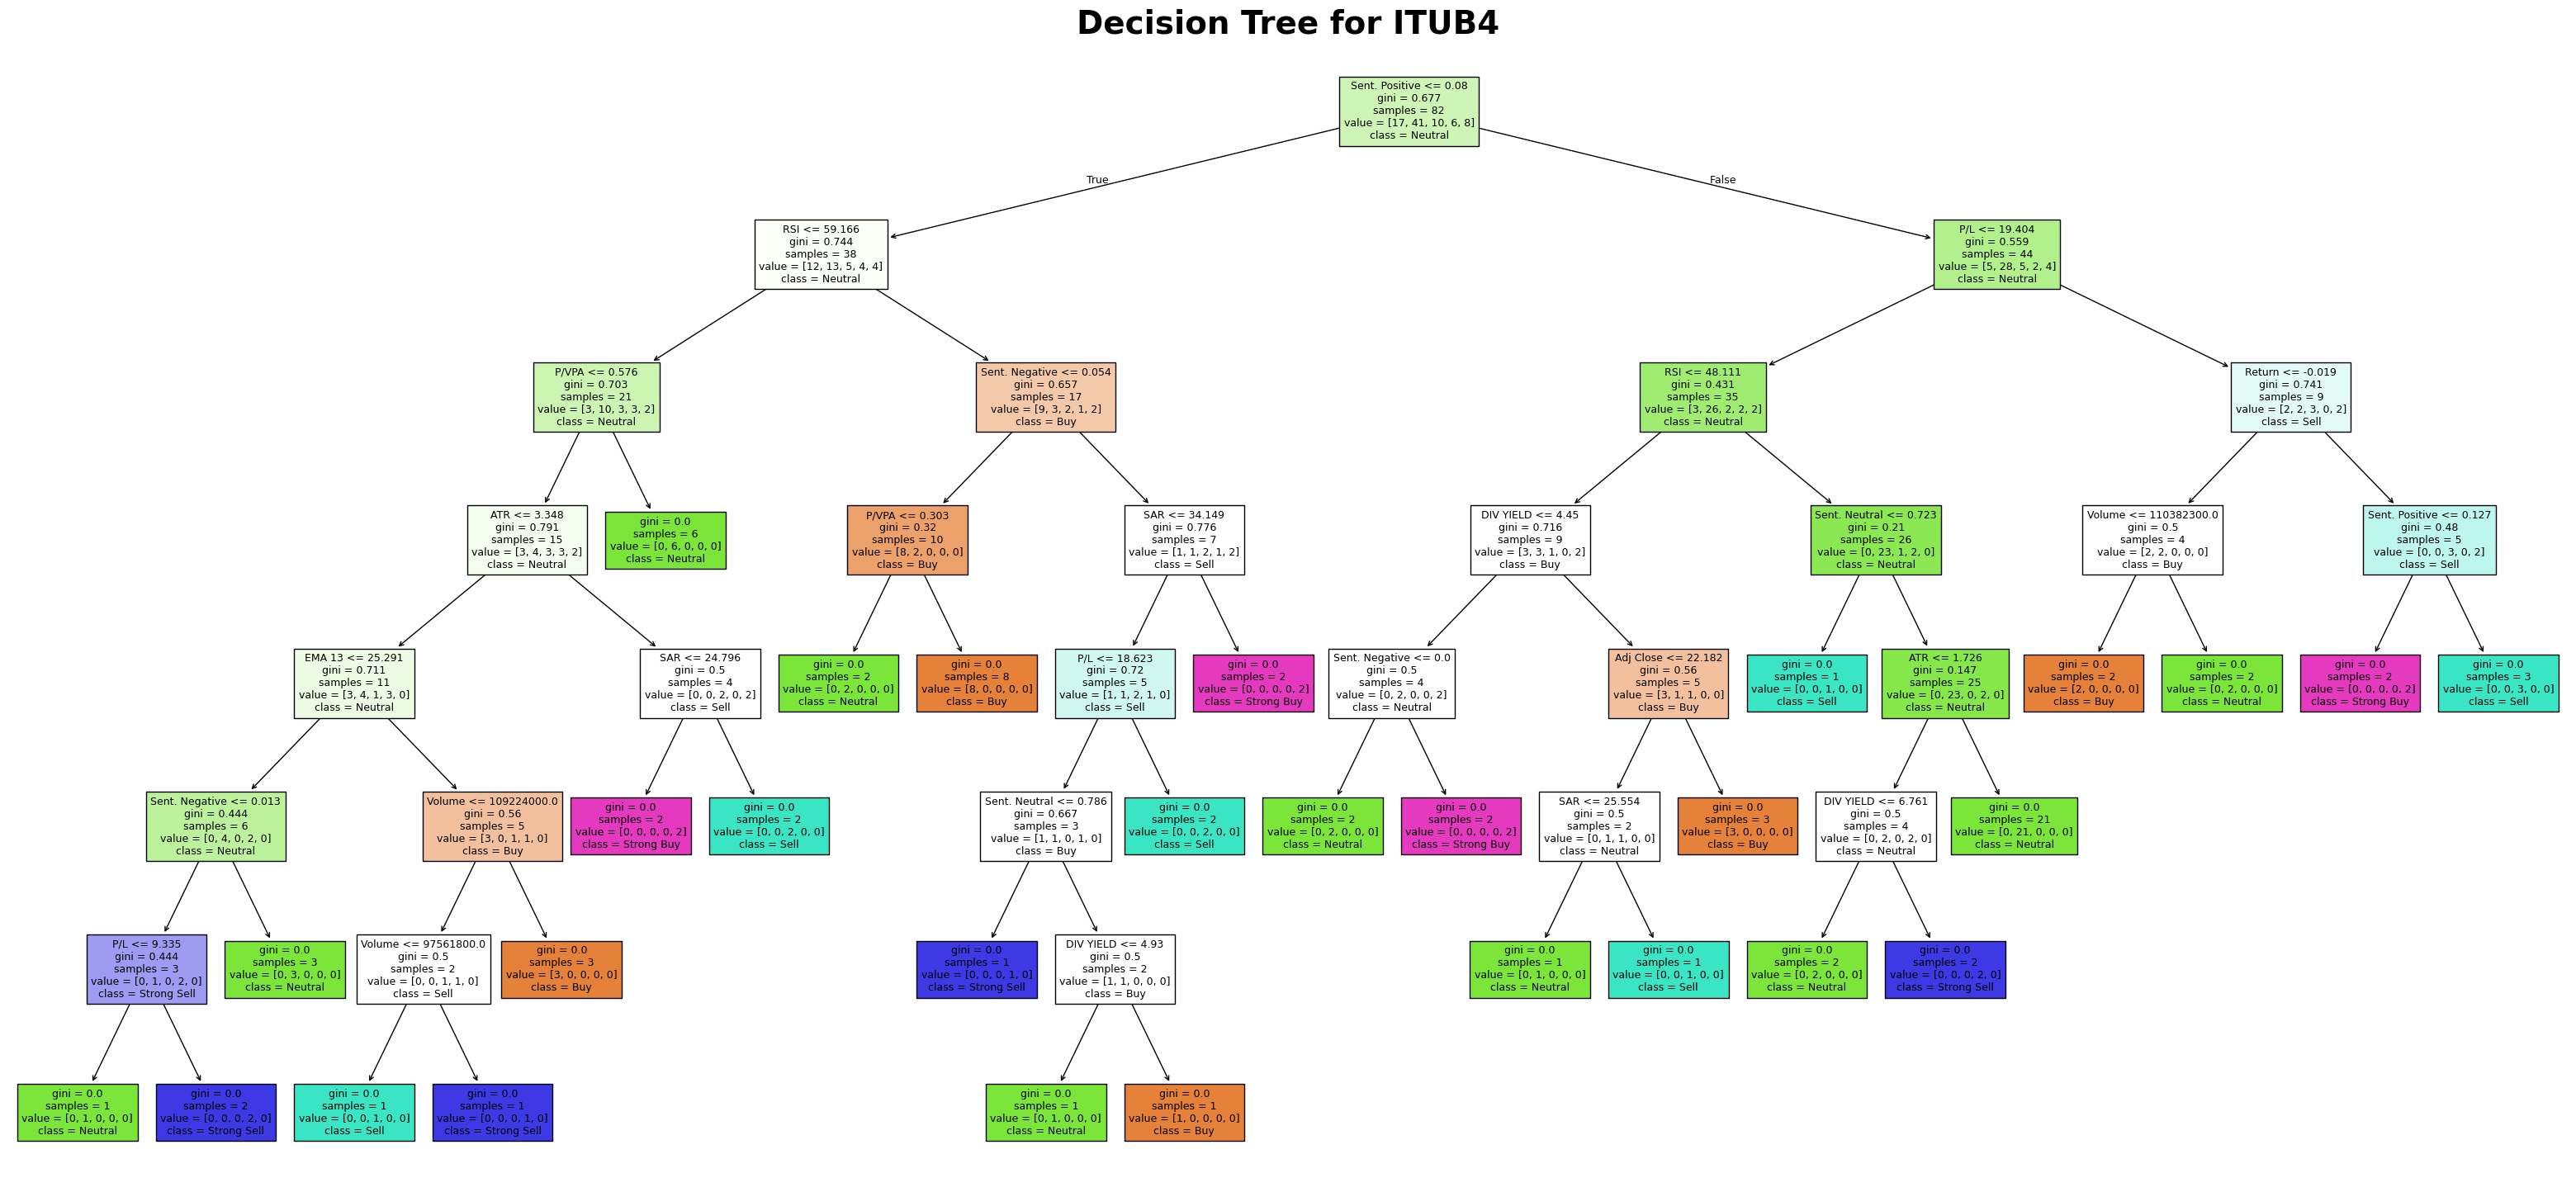

In [28]:
# Creating figure:
figura, axis = plt.subplots(nrows=1, ncols = 1, figsize = (40,18))

# Plotting Tree
tree.plot_tree(asset_tree,feature_names = features, class_names=class_labels, filled = True, fontsize=9)

# Title
axis.set_title("Decision Tree for ITUB4", fontsize=28, fontweight = 'semibold');

## 4. Random Forest

#### a) Creating Model

In [29]:
from sklearn.ensemble import RandomForestClassifier


for key, nested_dict in train_data_transformed.items():
    # Inicialize classifier:
    asset_classifier = RandomForestClassifier(n_estimators = 150, random_state=42)

    # Fit the model:
    asset_model = asset_classifier.fit(nested_dict['X_train'], nested_dict['Y_train'])


    # Store the model and importances:
    nested_dict['model'] = asset_model
    nested_dict['Importances'] = pd.DataFrame(asset_model.feature_importances_,
                                              columns = ['Importance'],
                                              index = nested_dict['df'].columns.tolist()[:-1]).sort_values('Importance', ascending = False)


#### b) Predictions and Accuracy:

In [30]:
print('Accuracy of Random Forest Models')
for key, nested_dict in test_data_transformed.items():
  # Load the asset model:
  asset_model = train_data_transformed[key]['model']

  # Compute predictions:
  nested_dict['Predictions'] = asset_model.predict(nested_dict['X_test'])
  acc = accuracy_score(nested_dict['Y_test'], nested_dict['Predictions'])
  print(f"Asset: {key}  | Accuracy: {round(acc*100,2)} %  ")

Accuracy of Random Forest Models
Asset: ABEV3  | Accuracy: 28.57 %  
Asset: B3SA3  | Accuracy: 28.57 %  
Asset: ELET3  | Accuracy: 19.05 %  
Asset: VALE3  | Accuracy: 14.29 %  
Asset: PETR4  | Accuracy: 14.29 %  
Asset: ITUB4  | Accuracy: 42.86 %  
Asset: IBOV  | Accuracy: 66.67 %  


#### c) Feature importance

In [31]:
for key, nested_dict in train_data_transformed.items():
  print(f' Asset: {key} \n', round(nested_dict['Importances']*100, 2))
  print('\n')

 Asset: ABEV3 
                 Importance
Sent. Neutral         9.85
RSI                   6.74
Sent. Negative        6.55
P/VPA                 6.42
SAR                   6.35
Adj Close             6.30
EMA 13                6.27
Sent. Positive        6.11
Return                6.01
DIV YIELD             5.63
Volume                5.62
P/L                   5.49
Upper Band            5.34
OBV                   5.28
Lower Band            4.71
ATR                   4.50
VPA TTM               1.24
EPS TTM               0.94
Dividends TTM         0.66


 Asset: B3SA3 
                 Importance
Return                8.76
Sent. Negative        8.32
Sent. Positive        7.92
Sent. Neutral         7.85
SAR                   6.77
EMA 13                6.18
ATR                   5.79
DIV YIELD             5.17
OBV                   5.02
P/VPA                 4.99
Volume                4.90
Upper Band            4.86
Lower Band            4.82
P/L                   4.37
Adj Close            

#### d) Confusion Matrix

In this section, a confusion matrix is generated to evaluate the classification model for the asset PETR4. The confusion matrix is a performance evaluation tool that summarizes the model's predictions by comparing actual and predicted classifications. Each row represents the actual class, while each column represents the predicted class, making it useful for assessing misclassifications and overall accuracy.

First, the trained model and corresponding datasets are extracted. Then, a confusion matrix is created and visualized using Yellowbrick’s ConfusionMatrix and Seaborn’s heatmap. The final plot provides an intuitive view of the model’s classification performance across different asset rating categories (Buy, Neutral, Sell, Strong Sell, Strong Buy).

0.14285714285714285

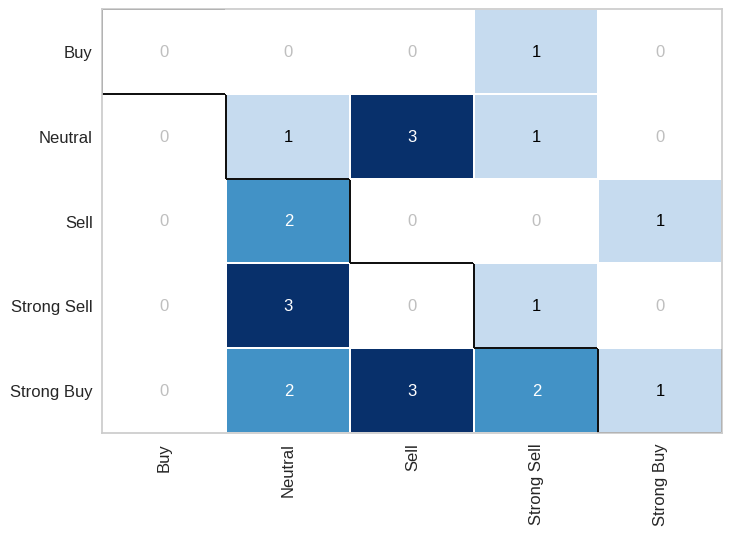

In [33]:
from yellowbrick.classifier import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration for PETR4:
asset = 'PETR4'
class_labels = ['Buy', 'Neutral', 'Sell', 'Strong Sell', 'Strong Buy']

# Extracting the data for 'PETR4'
asset_model = train_data_transformed[asset]['model']

X_train = train_data_transformed[asset]['X_train']
Y_train = train_data_transformed[asset]['Y_train']

X_test = test_data_transformed[asset]['X_test']
Y_test = test_data_transformed[asset]['Y_test']

# Creating and fitting the ConfusionMatrix visualizer
cm = ConfusionMatrix(asset_model, classes=class_labels, percent=False, cmap='Blues');
cm.fit(X_train, Y_train);
cm.score(X_test, Y_test)

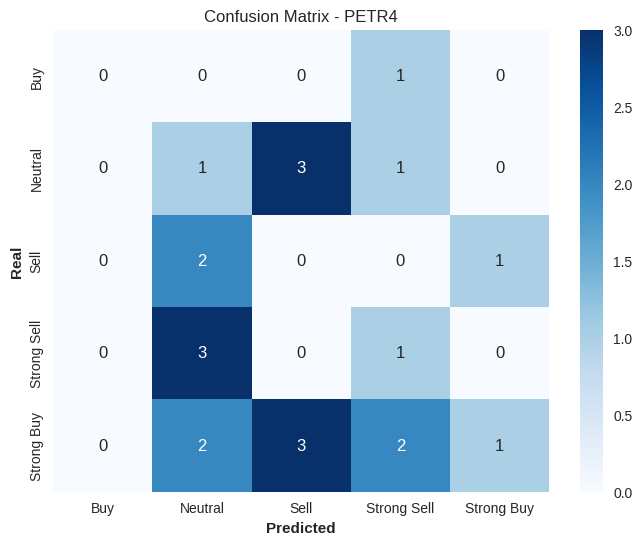

In [34]:
# Extracting the confusion matrix:
conf_matrix = cm.confusion_matrix_

# Plotting the confusion matrix:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

plt.title(f'Confusion Matrix - {asset}')
plt.xlabel('Predicted', fontweight = 'bold')
plt.ylabel('Real', fontweight = 'bold')
plt.show()
